# Project description

The company `Sweet Lift Taxi` has collected historical data on taxi orders at airports. Looking to attract more drivers at rush hours, we are asked to predict the quantity of taxi orders for the next hour. To make this possible we need to build a predictive model to do the corresponding predictions.

The metric that shall be used is `RMSE (Root Mean Squared Error)` and should not be greater than 48 on the test set.

## Project instructions:

1. Download the dataset and do an hourly resample.
2. Analize the data.
3. Train different models with a different hyperparameters set. The test set must be 10% of the initial dataset.
4. Test the data using the test set and show conclusions.

## Data description

Data is saved on the file `taxi.csv`.    
The number of orders is on column `num_orders`.

## Preparing the data

Before we can do some predictions on the current information we need to assure we can process it correctly. To make to possible we need to preprocess the information. Depending on the data we have is the addecuate preprocessing; For time series we need to check if is monotonic and in sampled on the required time periods.

This section will be divided on the following sub-sections:
1. Importing libraries
2. Reading the data
3. Preprocessing the data

### Importing libraries

The following modules/libraries will be the ones used on this project. We used libraries to manipulate datasets (`Pandas`), plotting data (`Matplotlib`), seasonal analysis (`Statsmodels`) and machine learning metrics and models (`Scikit-learn`, `LightGBM`, `XGBoost` and `CatBoost`).

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

### Reading the data

Once we have the needed modules let's read the dataset information. For time series is very practical to set a value for the Pandas function `read_csv()` on parameters `index_col` and `parse_dates`. On this way we can set the time series as the index and parse it on a datetime format.

In [2]:
data = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Preprocessing the data

Now let's continue to the preprocessing, in which we will determine two main points:

1. `Determine if time series can be interpreted as a monotonic function`.    
A monotonic function is a function between ordered sets that preserves or reverses the given order. This means it can be entirely increasing or entirely decreasing, in our case shall be entirely increasing. To determine if it is monotonic behaviour or not we will be using the Pandas method `is_monotonic` which will evaluate the index and sort it if method returns `False`, or remain the same if not.

In [4]:
if data.index.is_monotonic:
    print("Index is sorted correctly.")
else:
    data.sort_index(inplace=True)
    print("Index was not sorted correctly. Processing completed.")

Index is sorted correctly.


2. `Resampling the data`.    
We have our information sampled on instances of 10 minutes but we need to make predictions on an hourly base, so we need to resample the data hourly. Using the Pandas function `resample()` we can do this possible on any valid format, but we will use the input "1H" which means "1 hour" and sum the rows for all hours.

In [5]:
data = data.resample("1H").sum()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Analizing the time series

The next step is to comprehend how our time series behaves, so we need to analize it correctly. We need to generate new information to make this possible, but it can be difficult to comprehend the whole time series (this does not mean is not necessary) so we will complement it with the same analysis for the last month of the time series.

This section will be divided as following:
1. Rolling mean
2. Seasonal decompose
3. Time series diferrence

### Rolling mean

The rollimg mean, or moving average, is a calculation to analyze data points by creating a series of averages of different selections of the full data set. In other words, we can obtain the mean value for a specific point by taking a number of values on the series, the window size, and for each following point we drop the first value of the current window and add the following value of the series.

This new value is commonly used to smooth short-term fluctuations and highlight longer-term trends. Let's see the rolling mean on the whole time series.

#### Whole time series

Interpreting the whole time series we can conclude the following:

1. The mean value is increasing through all the series.
2. The last mean value is much greater than the initial mean value.

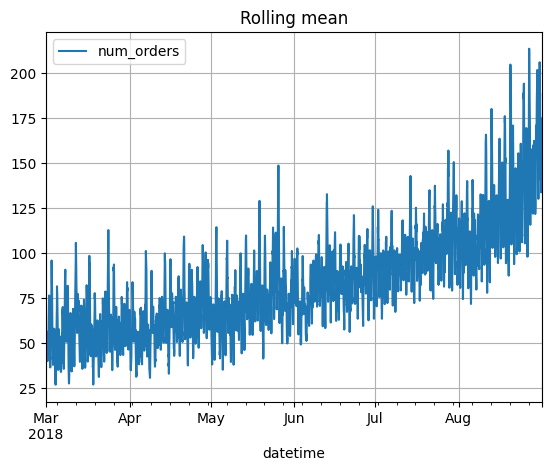

In [7]:
moving_mean = data.rolling(10).mean()

moving_mean.plot(grid=True)
plt.title("Rolling mean for taxi orders")
plt.show()

### Seasonal decompose

Another analysis for time series is decompose the series o its 4 main components: Tendency, Seasonality and Residue. Those 3 components define the following:

1. Tendency: Describe the orientation of the series (incresing or decreasing).
2. Seasonality: Describe beahaviour patters on the series.
3. Residue: Information which is not relevant for the analysis (also called noise).

#### Whole time series

Decomposing the whole time series we can conclude the following:

1. The tendency for the time series is mainly increasing.
2. The time series has a clear pattern, but it is difficult to determine its period.
3. The residue of the time series has a mean value near 0.

Let's analyze this decomposition for the August month and see if we can get a better insight.

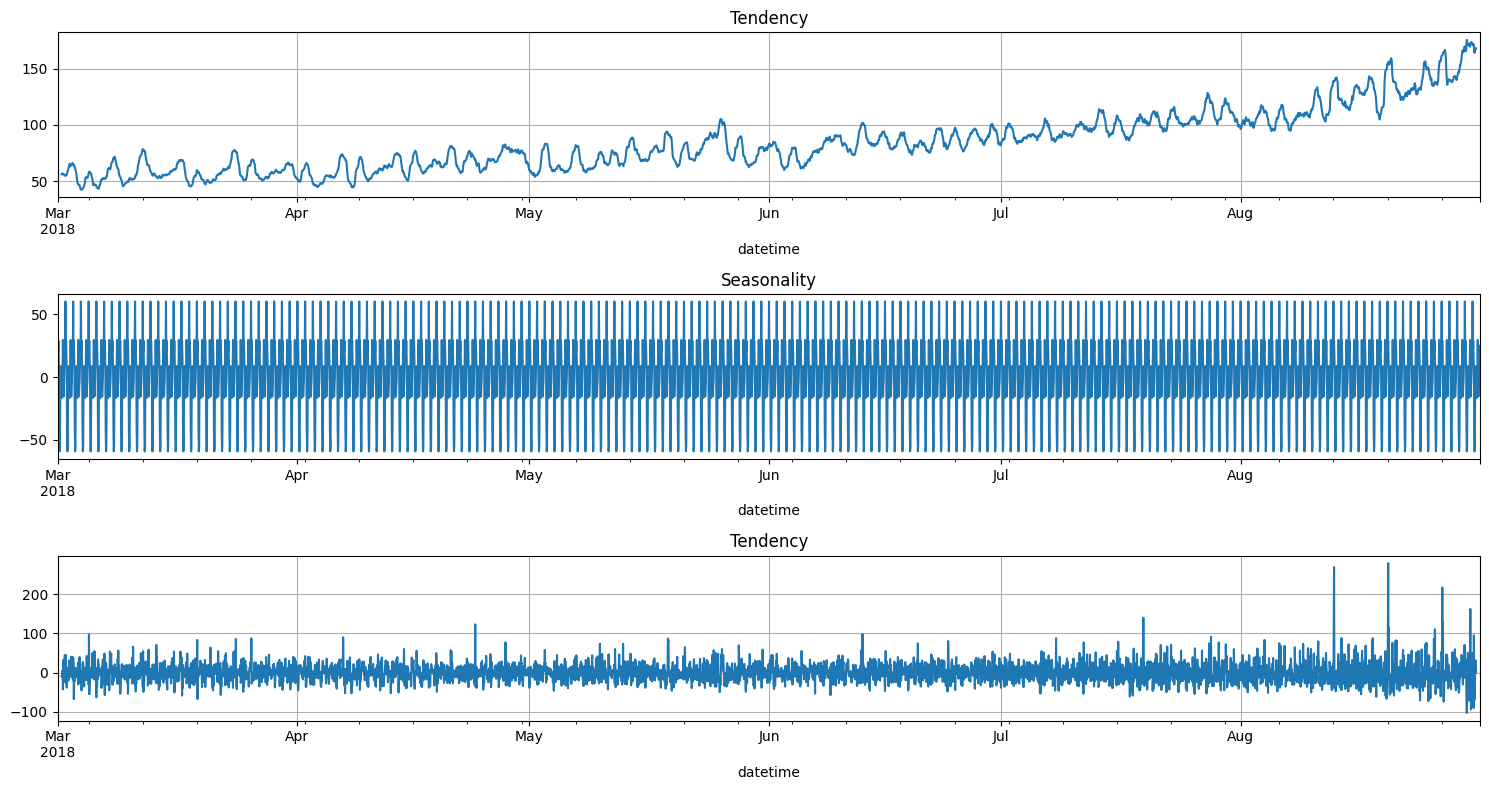

In [9]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15,8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), grid=True)
plt.title("Tendency")

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title("Seasonality")

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), grid=True)
plt.title("Residue")

plt.tight_layout()

#### August time series

Decomposing the series on August we can conclude the following:

1. Tendency remains the same orientation as in the whole series.
2. Now we can appreciate the seasonality has a daily pattern, with its greater values on the start, end and mid-right values of the series.
3. Residue values remains the same as in the whole series.

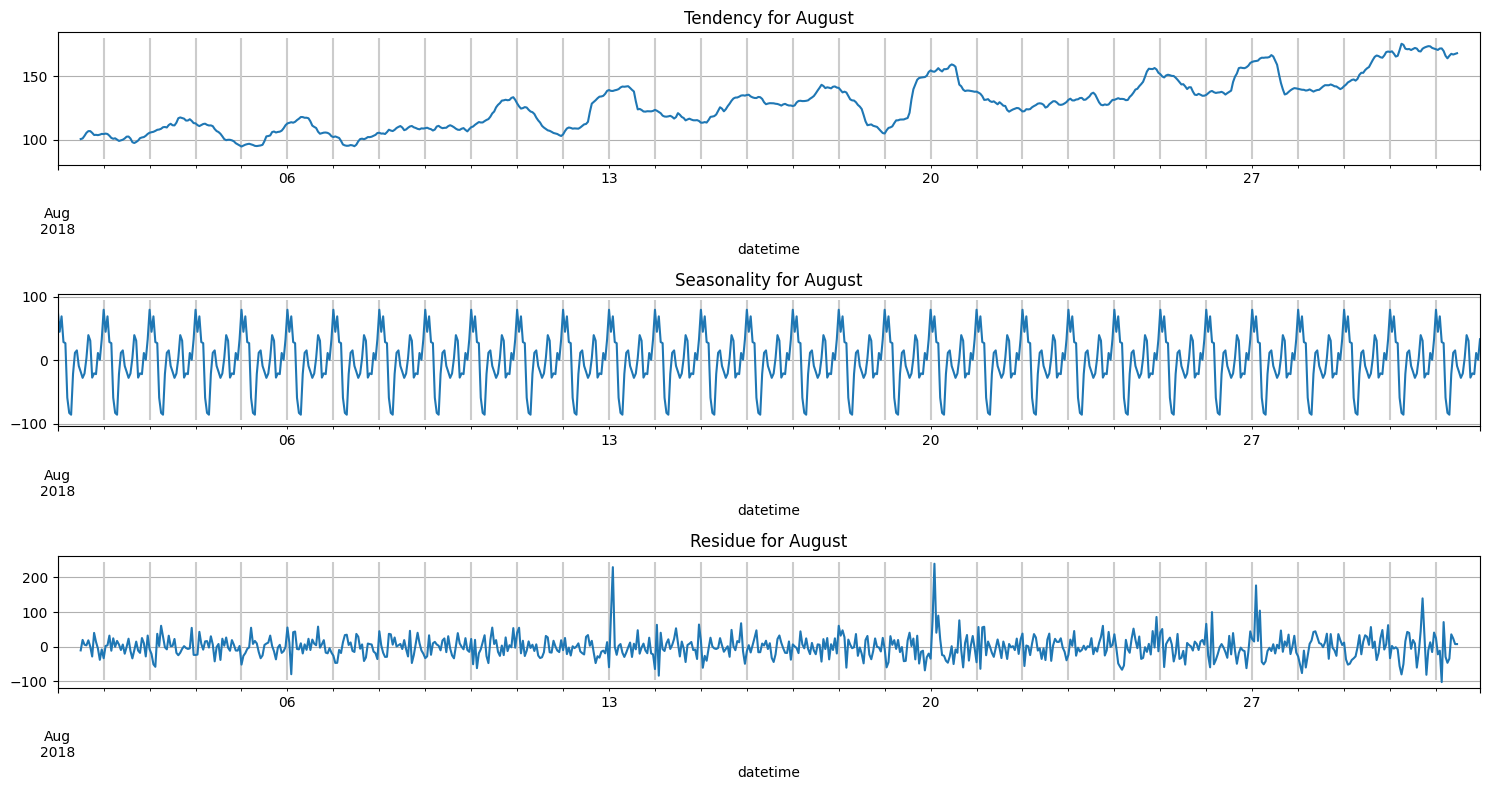

In [10]:
decomposed_test = seasonal_decompose(data["2018-08":])

indexes = data["2018-08"].resample("1D").sum()

plt.figure(figsize=(15,8))

plt.subplot(311)
decomposed_test.trend.plot(ax=plt.gca(), grid=True)
plt.vlines(indexes.index, 85, 180, colors="0.8")
plt.title("Tendency for August")

plt.subplot(312)
decomposed_test.seasonal.plot(ax=plt.gca(), grid=True)
plt.vlines(indexes.index, -95, 95, colors="0.8")
plt.title("Seasonality for August")

plt.subplot(313)
decomposed_test.resid.plot(ax=plt.gca(), grid=True)
plt.vlines(indexes.index, -95, 245, colors="0.8")
plt.title("Residue for August")

plt.tight_layout()

### Time series diferrence

Time series difference is a type of transformation in which we can achieve two main things:
1. Make a time series stationary (in case it is not).
2. Stabilizing the mean value of the time series.

This is also needed to be able to model properly our series and generate more accurate predictions. Let's apply it to the series.

#### Original time series

On the plot below we can see the distribution of orders in our original data. It seems sufficiently stationary and we could start working with it, but we can improve this process even more. The time series difference helps us to transform the time series in a "more-stationary" series, and this mean better model predictions.

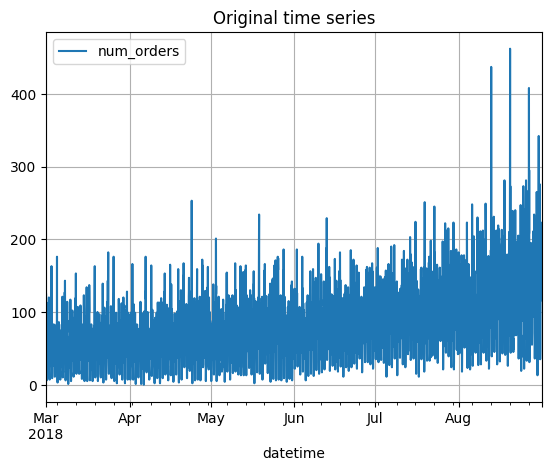

In [11]:
data.plot(grid=True)
plt.title("Original time series")
plt.show()

#### Differenced time series

Once a difference is applied to the time series we can see the differences between both of them:
1. The values are stabilized near 0.
2. Variances have lowered.
3. Are easier to interpret.

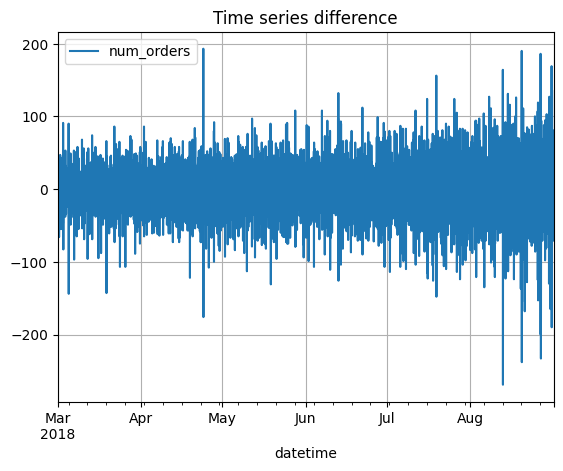

In [12]:
diff_data = data - data.shift(fill_value=0)

diff_data.plot(grid=True)
plt.title("Time series difference")
plt.show()

## Generating new features

Before the modeling process we need to generate new features which can help the models to make the predictions in an easier way. Those new features will be created on the function `make_features`:

1. `week_of_year`: The number of the week of the year for the current date.
1. `day`: The day of the current date.
1. `hour`: The hour of the current date.
1. `lag_X`: Features in which the time series values will change their locations. The offset on the values and the number of the "lag_X" column is defined by the input "lag_lenght", i.e.: if "lag_lenght = 3" there will be new columns "lag_1, lag_2 and lag_3" with offsets of 1, 2 and 3 respectively.
1. `rolling_mean`: Moving average value for the time series. The window size is determined by input "rolling_lenght".

In [13]:
def make_features(df, lag_lenght:int=3, rolling_lenght:int=5):

    # Generating new columns from dataframe index's timestamps components
    df["week_of_year"] = df.index.weekofyear
    df["day"] = df.index.day
    df["hour"] = df.index.hour

    # Generatig new lag columns from 1 to lag_lenght + 1
    for lag in range(1, lag_lenght + 1):

        # Offsetting the column values by lag value
        df["lag_{}".format(lag)] = df.iloc[:,0].shift(lag)

    # Generating moving average series with a "rolling_lenght" window size
    df["rolling_mean"] = df.iloc[:,0].shift().rolling(rolling_lenght).mean()

Generate new features with 5 lag columns and a rolling mean series with a window size of 10.

In [14]:
make_features(data, 5, 10)

In [15]:
data.head(11)

,num_orders,week_of_year,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,9,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,9,1,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,9,1,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,9,1,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,9,1,4,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 05:00:00,6,9,1,5,43.0,66.0,71.0,85.0,124.0,NaN
2018-03-01 06:00:00,12,9,1,6,6.0,43.0,66.0,71.0,85.0,NaN
2018-03-01 07:00:00,15,9,1,7,12.0,6.0,43.0,66.0,71.0,NaN
2018-03-01 08:00:00,34,9,1,8,15.0,12.0,6.0,43.0,66.0,NaN


## Modeling

Let's test various models and determine the best one for our application. Remember our target is to reach a RMSE value below 48. The models we will use are:

1. Linear Regression (for sanity test)
2. Random Forest Regressor
3. LightGBM
4. XGBoost
5. CatBoost

### Scaling and split data

Scaling the features for a better prediction accuracy.

In [16]:
scaler = StandardScaler()
data.iloc[:, 1:] = scaler.fit_transform(data.iloc[:, 1:])

Splitting the data in a relation 90/10 for the train and test set.

In [17]:
train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=0)

Dropping all rows with missing values and divide train and test sets in features and target.

In [18]:
train = train.dropna()

X_train = train.drop("num_orders", axis=1)
X_test = test.drop("num_orders", axis=1)
y_train = train["num_orders"]
y_test = test["num_orders"]

### Linear Regression - Sanity test

Applying a Linear Regression model as sanity test we achieved an RMSE value of `53.05`, 5 units above the threshold. This is not acceptable for our application, but is indeed a good comparison point for other models.

In [19]:
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = mse(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}.")
print(f"R2: {r2}.")

RMSE: 53.05493251778698.
R2: 0.17888586299714704.


### Random Forest Regressor

Using a Random Forest Regressor model and setting its hyperparameters as showing in the code block below we achieved an RMSE value of `46.03`, almost 2 units below the threshold. This value is enough for our application, but let's remember this model has higher processing times for big datasets and also lacks more "sophisticated" predictive methods (as the case of gradient boosting), so let's test other models and compare values.

In [20]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=5, random_state=0).fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = mse(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}.")
print(f"R2: {r2}.")

RMSE: 46.03082517862621.
R2: 0.3819131310567577.


### LightGBM

LightGBM is the first model with gradient boosting we will use, and with the parameters shown on the code block below we can achieve a RMSE value of `47.02`, almost 1 unit below the threshold. This value worse than the one obtained on the previous tree-based model, but the processing advantages are better than the RMSE values difference. However, let's see if we can improve this value with other models.

In [21]:
lgb_train = lgb.Dataset(X_train, label=y_train)

lgbm_params = {'learning_rate': 0.05, 
               'boosting': 'gbdt',
               'objective': 'regression',
               'metric': 'rmse',
               'num_leaves': 100,
               'max_depth': 10,
               'seed': 0}

model_lgbm = lgb.train(lgbm_params, lgb_train, 50)
y_pred = model_lgbm.predict(X_test)

rmse = mse(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}.")
print(f"R2: {r2}.")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 3964, number of used features: 9
[LightGBM] [Info] Start training from score 78.355701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
RMSE: 47.02750414407832.
R2: 0.35485719645337477.


### XGBoost

Using XGBoost, a tree ensemble model with gradient boosting, and the parameters shown in the code block below we achieved a RNSE value of `47.21`, almost 0.8 units below the threshold. Comparing XGBoost and LightGBM we can appreciate this first model is not addecaute for time series, maybe for the tree ensemble itself or other internal processing in the model.

In [22]:
xgb_train = xgb.DMatrix(X_train, label=y_train)

xgb_params = {'max_depth': 5,
              'objective': 'reg:squarederror',
              'eval_metric': 'rmse',
              'learning_rate': 0.08,
              'seed': 0}

model_xgbm = xgb.train(xgb_params, xgb_train, 300)
xgb_test = xgb.DMatrix(X_test)
y_pred = model_xgbm.predict(xgb_test)

rmse = mse(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}.")
print(f"R2: {r2}.")

RMSE: 47.21156321910664.
R2: 0.34979731652516455.


### CatBoost

CatBoost is the last model we will be using on the project. This model with the configuration shown on the code block below we can achieve a RMSE value of `45.12`, almost 3 units below the threshold. This is the RMSE value obtained with a processing time of 5 seconds approximately.

In [23]:
model_cat = CatBoostRegressor(iterations=100, learning_rate=0.1, loss_function="RMSE", random_seed=0)
model_cat.fit(X_train, y_train, verbose=10)
y_pred = model_cat.predict(X_test)
rmse = mse(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}.")
print(f"R2: {r2}.")

0:	learn: 36.7112142	total: 50ms	remaining: 4.95s
10:	learn: 27.5837795	total: 79ms	remaining: 639ms
20:	learn: 24.7369215	total: 107ms	remaining: 403ms
30:	learn: 23.6499849	total: 135ms	remaining: 301ms
40:	learn: 22.8422077	total: 165ms	remaining: 237ms
50:	learn: 22.3964150	total: 192ms	remaining: 185ms
60:	learn: 21.8964136	total: 220ms	remaining: 141ms
70:	learn: 21.5140038	total: 249ms	remaining: 102ms
80:	learn: 21.1374704	total: 277ms	remaining: 65ms
90:	learn: 20.8027996	total: 310ms	remaining: 30.6ms
99:	learn: 20.5332985	total: 337ms	remaining: 0us
RMSE: 45.12057860902888.
R2: 0.4061164212958368.


### Conclusions

The RMSE values obtained may vary depending on many variables:
1. Number of lag features
2. Number of date components features
3. Model used
4. Parameters setting

This is why obtaining the best results possible is an iterative process in which many posibilities should be tested.

Results obtained on the table below:

| Values | Linear Regression | Random Forest Regressor | LightGBM | XGBoost | CatBoost |
| ------ | ----------------- | ----------------------- | -------- | ------- | -------- |
| RMSE | 53.05 | 46.03 | 47.02 | 47.21 | 45.12 |
| $R^{2}$ score | 0.1788 | 0.3819 | 0.3548 | 0.3497 | 0.4061 |

## General conclusions

1. Is important to comprehend how the data of your time series is distributed and how you need to resample it. Once you comprehend what you have and what you need to continue your modeling process is easier to continue with the pre-processing of the data.

2. Is essential to generate new features on your time series dataset to help the model to make more accurate predictions. Testing different features distributions is essential to get the best results possible.

3. Testing different models can help on the search of better results. As we could see on section 6 depending on the model used is the result obtained, so testing different models with different parameters configuration is recommended for all projects.